<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/factorpricingmodel/factor-pricing-model-risk-model/blob/main/examples/notebook/crypto_statistical_risk_model.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/factorpricingmodel/factor-pricing-model-risk-model/blob/main/examples/notebook/crypto_statistical_risk_model.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

# Statistical Risk Model in Cryptocurrencies

The notebook is to demonstrate the building steps of constructing factor risk models in statistical approach (PCA) in cryptocurrencies.

Package [factor-pricing-model-risk-model](https://github.com/factorpricingmodel/factor-pricing-model-risk-model) is required in the building steps, while matplotlib is used for visualization.

In [1]:
!pip install matplotlib factor-pricing-model-risk-model


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from functools import partial
from numpy import isnan
import pandas as pd

from fpm_risk_model.dataset.crypto import (
    download_sample_data_estimation_universe,
    download_sample_data_model_universe,
)
from fpm_risk_model.rolling_factor_risk_model import RollingFactorRiskModel
from fpm_risk_model.cov_estimator import RollingCovarianceEstimator
from fpm_risk_model.statistical import PCA

# Load top 50 marketcap historical data from Kaggle dataset

The API function `download_sample_data_estimation_universe` downloads the top 50 marketcap historical data from Kaggle [dataset](https://www.kaggle.com/datasets/sudalairajkumar/cryptocurrency-historical-prices-coingecko). The price history starts from 2015.


###### Note: The dataset is synchronzed with CoinGecko every day, but due to API keys required in downloading Kaggle data, only the snapshot is provided.

In [62]:
sample_data_estimation_universe = download_sample_data_estimation_universe()
est_universe_prices = sample_data_estimation_universe["prices"]
est_universe_returns = (
    sample_data_estimation_universe["returns"]
    .clip(lower=-0.2, upper=0.2)
)
est_universe_volumes = sample_data_estimation_universe["volumes"]
est_universe_marketcap = sample_data_estimation_universe["marketcap"]

# Construct estimation universe

Estimation universe is constructed by selecting the instruments by the following
criteria in the ascending order

1. Active trading for at least 6 months
2. Median of past 6-month daily (absolute) returns should exceed 0.5% (Stablecoin exclusion)
3. Rank the instruments by market cap and exclude the lower rank instruments if they are
   highly correlated with other instruments. (For example, ETH and staked Ether)

A ranking function `correlation_rank_selection` is defined to sort the instruments in rank first, and then select the instruments in ranking order. If the instrument is closely correlated to any instruments selected on the date, it will be excluded.

In [4]:
def correlation_rank_selection(
    d_rank,
    returns,
    rolling_window=90,
    correlation_threshold=0.9
):
    if d_rank.isnull().all():
        return pd.Series(np.nan, index=d_rank.index)
    ranks = d_rank.sort_values()
    validity = ranks.notnull()
    d_correlations = returns.loc[:d_rank.name, validity].iloc[-rolling_window:].corr()
    selected = []
    for name, i_validity in ranks.items():
        if np.isnan(i_validity):
            continue
        if not selected:
            selected.append(name)
            continue
        if (d_correlations.loc[selected, name].abs() > correlation_threshold).any():
            continue
        selected.append(name)
    valid_instmts = pd.Series(True, index=selected)
    valid_instmts = valid_instmts.reindex(d_rank.index)
    return valid_instmts

<Axes: title={'center': 'Number of valid instruments in universe'}>

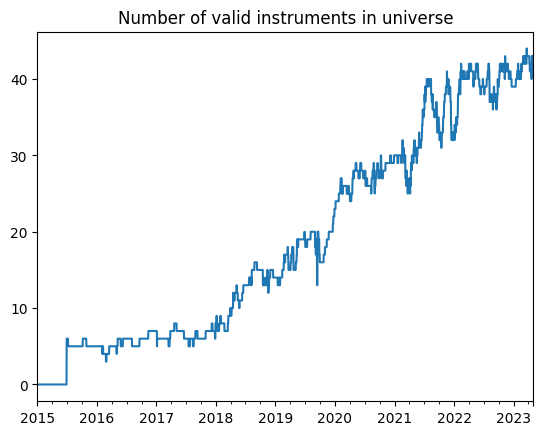

In [5]:
est_universe_validity = (est_universe_marketcap > 0.0).rolling(210, min_periods=180).sum() > 180
est_universe_validity = (
    est_universe_validity &
    (est_universe_returns.abs().rolling(210, min_periods=180).median() > 0.005)
)
est_universe_marketcap_rank = est_universe_marketcap.where(est_universe_validity).rank(axis=1, ascending=False)
est_universe_validity = (
    est_universe_marketcap_rank.apply(partial(correlation_rank_selection, returns=est_universe_marketcap_rank, rolling_window=90), axis=1)
    .fillna(False)
)
est_universe_validity.index = pd.to_datetime(est_universe_validity.index)
est_universe_validity.sum(axis=1).plot(title="Number of valid instruments in universe")

# Build factor risk model from estimation universe

After defining the scope of estimation universe, we can then compute the factor model with specifying its statistical models. A straightforward approach, [PCA](https://factor-pricing-model-risk-model.readthedocs.io/en/latest/risk_model/statistical/pca.html), is selected to generate the risk model in a rolling window of 180 days. In the meantime, due to the volatile market movement in cryptocurrencies, the daily returns beyond +/-20% is filtered out in running the risk model.

The building steps are as follows.

1. Define PCA model with parameter `n_components`, which can be integers, number of components to keep, or between 0 and 1, the percentage of the amount of variance that needs to be explained. In the example, the value `0.9` means to select the number of components such that the amount of variance that needs to be explained is greater than 90%.

2. Create an object of rolling factor risk model and define the number of rolling days. Parameter `show_progress` indicates to print the current progress of computation in rolling.

3. Pass the returns and the universe validity into into the `fit` method.

In [6]:
model = PCA(n_components=0.9)
rolling_risk_model = RollingFactorRiskModel(
    window=180,
    model=model,
    show_progress=True,
)
rolling_risk_model.fit(
    est_universe_returns.where(est_universe_returns.abs() < 0.20),
    validity=est_universe_validity,
)

For example, we can get the correlation matrix from the rolling risk model and see that Bitcoin and Ethereum are 90% correlated.

In [7]:
instruments = ["bitcoin", "ethereum"]
rolling_risk_model.get("2023-04-30").corr().loc[instruments, instruments]

,bitcoin,ethereum
bitcoin,1.000000,0.899209
ethereum,0.899209,1.000000


# Load all crypto OHLCV data

Similarily, he API function `download_sample_data_model_universe` will download a snapshot of model universe data. The data includes 1000 cryptocurrencies since 2014.

Again, though the dataset is updated in [Kaggle](https://www.kaggle.com/datasets/usamabuttar/cryptocurrency-historical-prices-updated-daily) every day, only a snapshot of dataset is provided here. If you are interested, you can go to the Kaggle site to download the latest one.

Please note that the prices in this dataset is leading that those in the estimation universe one. To align the datetimes between the two sets, all the attributes in model universe are shifted by 1 day.

In [58]:
sample_data_model_universe = download_sample_data_model_universe()
model_universe_prices = sample_data_model_universe["prices"].shift()
model_universe_returns = (
    sample_data_model_universe["returns"]
    .shift()
    .clip(lower=-0.2, upper=0.2)
)
model_universe_volumes = sample_data_model_universe["volumes"].shift()
model_universe_volumes_usd = model_universe_volumes * model_universe_prices

# Construct model universe

Model universe is constructed by selecting the instruments by the following
criteria in the ascending order

1. Active trading for at least 6 months
2. Median of past 6-month daily (absolute) returns should exceed 0.5% (Stablecoin exclusion)
3. Top 50% average daily volume (rolling 90 day median) among all instruments


<Axes: title={'center': 'Number of valid instruments in universe'}>

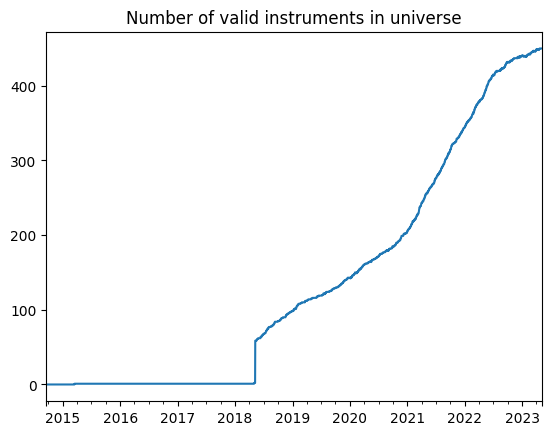

In [9]:
model_universe_validity = (model_universe_volumes > 0.0).rolling(210, min_periods=180).sum() > 180
model_universe_validity = model_universe_validity & (model_universe_returns.abs().rolling(210, min_periods=180).median() > 0.005)
model_universe_volume_usd_rank = (
    model_universe_volumes_usd
    .rolling(90, min_periods=60)
    .median()
    .where(model_universe_validity)
    .rank(axis=1, ascending=False)
)
model_universe_volume_usd_rank = (
    model_universe_volume_usd_rank
    .where(model_universe_volume_usd_rank.lt(model_universe_validity.sum(axis=1) * 0.5, axis=0))
)
model_universe_validity &= model_universe_volume_usd_rank
model_universe_validity.index = pd.to_datetime(model_universe_validity.index)
model_universe_validity.sum(axis=1).plot(title="Number of valid instruments in universe")

# Transform the risk model from estimation to model universe

The transformation reuses the factor returns to compute the new set of factor exposures and idiosyncratic returns on the model universe, even though the instrument names on the two universes are different.

It gives covariance matrix on a much larger number of instruments. For example, in 2023, the number of instruments in estimation and model universes are around 40 and 400 respectively.

In [10]:
rolling_risk_model.transform(
    model_universe_returns,
    validity=model_universe_validity,
)

# Forecasting accuracy

After the risk model has been transformed into the model universe space, it is important to examine its forecasting accuracy.

In the library, the following methods are provided

1. Bias statistics
2. Value at Risk (VaR)

Both methods require passing the rolling risk model and the portfolio weights. The portfolio weights should be a Dataframe
indicating the instrument weights per date and each date the weights should be summed up to 1. With portfolio weights,
the portfolio realized volatility, produced by its weights and returns, is compared with the forecast volatility produced
by risk models.

In the following example, an equal weighted portfolio is chosen in the analysis. The bias statistics is computed in a rolling window of 63 days. From the [definition](https://factor-pricing-model-risk-model.readthedocs.io/en/latest/accuracy/bias.html) of bias statistics, the 95% confidence bounds is between 0.82 and 1.17. We can see the bias is sometimes beyond the bounds but oscillate around 1.0. Above 1 means the covariance is underestimated, and vice versa.

<Axes: >

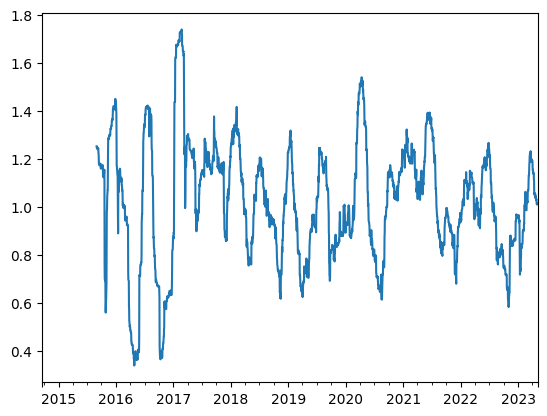

In [56]:
from fpm_risk_model.accuracy import compute_bias_statistics
weights = model_universe_validity.div(model_universe_validity.sum(axis=1), axis=0)
bias_statistics = compute_bias_statistics(
    X=model_universe_returns,
    weights=weights,
    window=63,
    rolling_risk_model=rolling_risk_model,
)
bias_statistics.plot()

Also, we can compute the VaR statistics with the assumption of equal weighted portfolio. From the [definition](https://factor-pricing-model-risk-model.readthedocs.io/en/latest/accuracy/value_at_risk.html) of VaR breach statistics, it is expected to be within 5%. Rather than suggesting the model overestimates or underestimates the covariance, the breach statistics describes only the two side violation.

<Axes: >

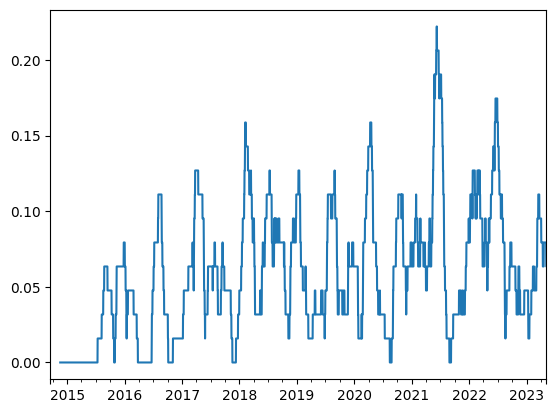

In [12]:
from fpm_risk_model.accuracy import compute_value_at_risk_rolling_breach_statistics
weights = model_universe_validity.div(model_universe_validity.sum(axis=1), axis=0)
var_breach_statistics = compute_value_at_risk_rolling_breach_statistics(
    X=model_universe_returns,
    weights=weights,
    window=63,
    rolling_risk_model=rolling_risk_model,
)
var_breach_statistics.plot()

## Covariance Estimator

Covariance estimator is another way to retrieve covariances from the factor models
with advanced techniques.

We can adjust the covariance with a short term volatility to enhance its forecasting
accuracy with the following steps

1. Compute an EWMA volatility `ewma_vol` with a half-life period of 90 days.
2. Create a covariance estimator object `RollingCovarianceEstimator`
3. Generate all the covariances given the EWMA volatility `cov(volatility=ewma_vol)`

Since the rolling risk model object does not store directly the covariance but
only the factor model components, e.g. factor returns and factor covariances,
you can pass the rolling risk model object into various parameters of covariance
estimators.

In [59]:
ewma_vol = model_universe_returns.ewm(halflife=90, min_periods=45).std()
pca_ewma_adj_vol_covs = (
    RollingCovarianceEstimator(rolling_risk_model)
    .cov(volatility=ewma_vol)
)
pca_ewma_adj_vol_covs_bias_statistics = compute_bias_statistics(
    X=model_universe_returns,
    weights=weights,
    window=63,
    rolling_risk_model=pca_ewma_adj_vol_covs,
)
pca_ewma_adj_vol_covs_var_breach_statistics = compute_value_at_risk_rolling_breach_statistics(
    X=model_universe_returns.where(model_universe_returns.abs() < 0.2),
    weights=weights,
    window=63,
    rolling_risk_model=pca_ewma_adj_vol_covs,
)

Covariance estimator also supports various covariance shrinkage methods. For example,
we can shrink the covariances with a constant of delta 0.4. Given the sample covariance
matrix `S`, the average variances `mu` of all the instruments are computed, and the 
covariances are estimated as follows,

```
S' = (1 - delta) * S + delta * mu * I
```

where `I` is an identity matrix with the same size as `S`.

In [70]:
pca_ewma_adj_vol_const_shrinkage_covs = (
    RollingCovarianceEstimator(rolling_risk_model, shrinkage_method="constant", delta=0.2)
    .cov(volatility=ewma_vol)
)
pca_ewma_adj_vol_covs_const_shrinkage_bias_statistics = compute_bias_statistics(
    X=model_universe_returns,
    weights=weights,
    window=63,
    rolling_risk_model=pca_ewma_adj_vol_const_shrinkage_covs,
)
pca_ewma_adj_vol_covs_const_shrinkage_var_breach_statistics = compute_value_at_risk_rolling_breach_statistics(
    X=model_universe_returns,
    weights=weights,
    window=63,
    rolling_risk_model=pca_ewma_adj_vol_const_shrinkage_covs,
)

# More model comparison

With forecasting accuracy, we can compare the benchmark model (PCA) with various types of models. For example, we can derive an APCA model with a shorter window (90 days) but a higher variance explanation percentage (95%).

The below first constructs and transforms an APCA risk model, and finally
compares with PCA risk model

In [68]:
from fpm_risk_model.statistical import APCA
model = APCA(n_components=0.95)
rolling_apca_risk_model = RollingFactorRiskModel(
    window=90,
    model=model,
    show_progress=True,
)
rolling_apca_risk_model.fit(
    est_universe_returns,
    validity=est_universe_validity,
)
rolling_apca_risk_model.transform(
    model_universe_returns,
    validity=model_universe_validity,
)

apca_bias_statistics = compute_bias_statistics(
    X=model_universe_returns,
    weights=weights,
    window=63,
    rolling_risk_model=rolling_apca_risk_model,
)
apca_var_breach_statistics = compute_value_at_risk_rolling_breach_statistics(
    X=model_universe_returns,
    weights=weights,
    window=63,
    rolling_risk_model=rolling_apca_risk_model,
)

# Result

Finally, we can compare the bias and VaR breach statistics among the four models,
and observe the follows in the graphs

1. PCA is the stable benchmark for comparison
2. APCA does not work better even theoretically it should give better short term
   variance predictions
3. PCA adjusted with short term EWMA volatility gives a slightly better result
   than the benchmark
4. Constant shrinkage delta does not give a sufficiently stable result



<Axes: title={'center': 'VaR Breach comparison'}>

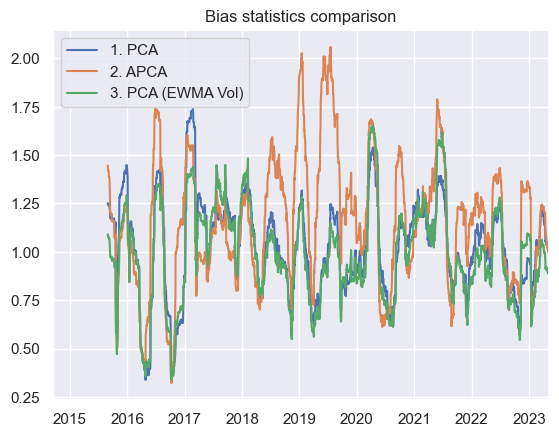

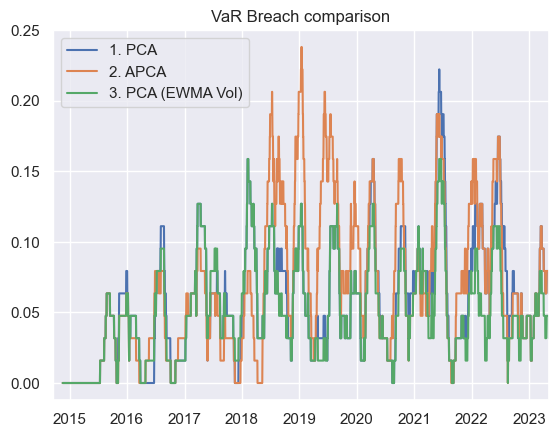

In [76]:
pd.concat({
    '1. PCA': bias_statistics,
    '2. APCA': apca_bias_statistics,
    '3. PCA (EWMA Vol)': pca_ewma_adj_vol_covs_bias_statistics,
    '4. PCA (EWMA Vol + Const Shrinkage)': pca_ewma_adj_vol_covs_const_shrinkage_bias_statistics,
}, axis=1).plot(title="Bias statistics comparison")

pd.concat({
    '1. PCA': var_breach_statistics,
    '2. APCA': apca_var_breach_statistics,
    '3. PCA (EWMA Vol)': pca_ewma_adj_vol_covs_var_breach_statistics,
    '4. PCA (EWMA Vol + Const Shrinkage)': pca_ewma_adj_vol_covs_const_shrinkage_var_breach_statistics,
}, axis=1).plot(title="VaR Breach comparison")

For further questions, please do not hesitate to reach out the maintainers of project [factor-pricing-model-risk-model](https://github.com/factorpricingmodel/factor-pricing-model-risk-model). Hope you enjoy it!